<a href="https://colab.research.google.com/github/AnnaJiang1308/Awesome-Hyperbolic-Learning/blob/main/Scene_Graph_Generation%2C_Compression%2C_and_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scene Graph Generation, Compression, and Classification on Action Genome Dataset
CS224W (21/22 Fall) Project from Zhuoyi Huang & Tina Li

---











## 1. Colab Tutorial Introduction



In this tutorial session we will have a closer look at how to apply **Scene Graph Generation and Compression on Action Genome Dataset**. <br>

Rather than teaching you how to use PyG libraries to solely do some downstream tasks, we think there's a gap between how to format customized image datasets into graph-structured datasets (i.e., scene graph generation), and then perform graph-based downstream tasks (i.e., graph compression and classification) on these graph structures. <br>

Our Colab Tutorial will act as an example for you to know the whole process, we will walk you through the codes that can be excuted to perform the task and will cover the following key points: <br>

1. Generating Scene Graph for the frames of the Action Genome Dataset
2. Compress graph structure to improve efficiency for downstream graph tasks such as graph classification (i.e., action classification)
3. Perform graph classification task on scene graphs generated by step 1 and compressed by step 2 and analyze the results



### 1.1 Scene Graph Generation
Scene graphs are a representation for image information in graph form. Each scene graph encodes objects as nodes, which are connected by pairwise relationships as edges.

Here we can formulate the task as a **Graph Generation task** (in contrast to Graph classification, node prediction, or edge prediction). We take the **images** as the frames from videos in Action Genome as input. First, we apply an object detection benchmark adapted from **Mask R-CNN** and detect the **bounding boxes** (red rectangles) and **object labels** (texts on the top-left corner of rectangles) for each image.

Given the objects as **nodes** of the scene graph, we predict the relationship between two nodes as the **edges**. For example, *has, behind, on*. etc. The nodes and the edges together forms a **scene graph** of a image, which is just the itermediate output of our task.


![picture](https://drive.google.com/uc?export=view&id=1Ii0Oxq5jeZuRFzb54_wK8LQgHVZsKIGH)

### 1.2 Scene Graph Compression

After getting the representation of a Scene Graph:

> The nodes and their attributes: Objects detected and their labels. <br>
The edges and their attributes: Relationshiop between objects and the type of the relationship.

We can perform graph compression to reconstruct each original full graph into a smaller graph representation.

### 1.3 Scene Graph Classification

Finally, after going through an encoder and a decoder of graph compression, we classify the scene graphs for an action label to evaluate the performance of our scene graph generation and graph compression models.

Specifically, we choose the action label **"using a phone"** for this tutorial, so frames can be classified as:
> label 1: "using a phone" <br>
> label 0: "not using a phone"

### 1.4 Action Genome Dataset Overview

[Action Genome](https://www.actiongenome.org/) is proposed by [Action Genome: Actions as Composition of Spatio-temporal Scene Graphs](https://arxiv.org/abs/1912.06992) (2019). It is a video database with an aim to bridge human actions and human-object relationships.

Here is a list of important statistics about the dataset.
> 10K Videos <br>
> 265K Labeled Frames <br>
> 157 Action Categories <br>
> 583K Bounding Boxes of Interacted Objects <br>
> 0.4M Object Instances with 35 Object Categories <br>
> 1.7M Human-Object Relationship Instances with 25 Relationship Categories <br>




### 1.5 Download Action Genome Dataset

The first step of our tutorial is to prepare the Action Genome dataset that we are going to generate scene graph on.

The frames can be directly downloaded from [Action Genome's website](https://www.actiongenome.org/). Since it is a large dataset, we have already helped you upload the frames onto a [Google Drive folder](https://drive.google.com/drive/folders/1TPrMtjhEfnoMUi4EL4VNkiem1ooP9kW3). Please add a shortcut to your Google Drive, so you can mount it and run the following cells.

*You need to first create a soft link of our public project folder (including codes, dependencies, and most importantly, datasets).*

 *Mount Google Drive for loading visual genome dataset from it.*



In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## 2. Environment Configuration

### 2.1 Install Dependencis

*This installs the right pip and dependencies for the fresh python.*

In [ ]:
!pip install ipython
!pip install scipy
!pip install h5py

This install scene_graph_benchmark and coco api dependencies.

In [ ]:
!pip install ninja yacs cython matplotlib tqdm opencv-python overrides

     |████████████████████████████████| 108 kB 4.4 MB/s 


This verifies the torch and cuda version.

In [ ]:
import os
import torch
import json
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

torch:  1.10 ; cuda:  cu111


This installs the PyG (PyTorch Geometric) library.

In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
  !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 3.7 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 3.5 MB 4.2 MB/s 
     |████████████████████████████████| 370 kB 4.2 MB/s 
     |████████████████████████████████| 482 kB 32.9 MB/s 
     |████████████████████████████████| 41 kB 654 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581968 sha256=10e96ec2c12b45f116500bbf446995b7167c3380cd4abc304ea0c15d46bc3bbb
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


### 2.2 Install Pycocotools

In [ ]:
# install pycocotools
%cd /content/drive/MyDrive/cs224w
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!python setup.py build_ext install

/content/drive/MyDrive/cs224w
fatal: destination path 'cocoapi' already exists and is not an empty directory.
/content/drive/MyDrive/cs224w/cocoapi/PythonAPI
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
running install
running bdist_egg
running egg_info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/cocoeval.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.7/pycoc

### 2.3 Install Apex

This might take about 15-20 minutes to finish.

In [ ]:
%cd /content/drive/MyDrive/cs224w
# install apex, this might take about 15-20 minutes
!git clone https://github.com/NVIDIA/apex.git
%cd apex
!python setup.py install --cuda_ext --cpp_ext

/content/drive/MyDrive/cs224w
fatal: destination path 'apex' already exists and is not an empty directory.
/content/drive/MyDrive/cs224w/apex


torch.__version__  = 1.10.0+cu111


setup.py:67: UserWarning: Option --pyprof not specified. Not installing PyProf dependencies!
  warnings.warn("Option --pyprof not specified. Not installing PyProf dependencies!")

Compiling cuda extensions with
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
from /usr/local/cuda/bin

running install
running bdist_egg
running egg_info
writing apex.egg-info/PKG-INFO
writing dependency_links to apex.egg-info/dependency_links.txt
writing top-level names to apex.egg-info/top_level.txt
adding license file 'LICENSE'
writing manifest file 'apex.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running

### 2.4 Install and compile Scene-Graph Generation Model

In [ ]:
%cd /content/drive/MyDrive/cs224w
# install PyTorch Detection
!git clone https://github.com/Yvonne0413/SceneGraph.git
%cd SceneGraph
!python setup.py build develop
%cd /content/drive/MyDrive/cs224w

## 3. Data Preparation on Action Genome
Since the whole Action Genome dataset is huge, we cannot load the whole dataset to google drive, so we have uploaded a subset of Action Genome, and get the annotation file of the subset of our Action Genome dataset. For all the frames of the selected subset of Action Genome in folder `/content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/frames_bicls`, we can load the annotation from `/content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/anno_frames_bicls`.

For the format of annotation file, it is a list of hash maps for each video frame, where each item has three keys for a video frame sample:

> The `video_id` maps to the video id string `XXXXX` (a mixure of numbers and capital letters)
The `label_name` maps to the frame's label name `cxxx`
The `label_id` maps to the frame's label id `0` or `1`.


We derived them from the annotation of Charades dataset, since Action Genome dataset is built on Charades dataset.

In [ ]:
img_root = '/content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/frames_bicls_2'
ann_root = '/content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/anno_frames_bicls'
ann_list = []

with open(ann_root + '/scene_validation_annotations.json') as f:
  anno_list = json.load(f)
count = 0
for img in os.listdir(img_root):
  if img.endswith('.png'):
    count += 1
print("There is total %d images in the subset of Action Genome."%count)
print("An annotation example of a single frame is:\n", anno_list[100])

Here we have mapped label_name to label_id for better representation, so that there's an additional attribute for each frame named as label_id(index from 0). We can get from the

In [ ]:
label_map = {}
count = 0
for sample in anno_list:
  if sample['label_name'] not in label_map:
    label_map[sample['label_name']] = sample['label_id']
    count += 1
print("There are total %d classes of labels for all the frames."%len(label_map))
print(label_map)
print("c097 here is Walking through a doorway")
print("c015 here is Holding a phone/camera")

## 4. Scene Graph Generation



### 4.1 Scene-Graph Generator Model Definition



To generate scene graphs on the 400 frames of Action Genome, we use a pre-trained state-of-the-art **Neural Motifs** model based on [Neural Motifs: Scene Graph Parsing with Global Context](https://arxiv.org/abs/1711.06640) (2018).

We also use the **SUM fusion function** and **Total Direct Effect (TDE)** analysis framework based on [Unbiased Scene Graph Generation from Biased Training](https://arxiv.org/abs/2002.11949) (2020).

As shown below, the final predicate logits Y is generated by using the SUM fusion function that sums together the inputs from three branches I (image), X (object features), and Z (object labels).

For evaluation, we use **Relationship Retrieval** metrics and **Scene Graph Detection (SGDet)** task, which detects scene graphs from scratch.

The model was trained using the conventional cross-entropy losses of object labels and predicate labels.
![picture](https://drive.google.com/uc?export=view&id=1gKjTxlJn6dLSTdabqJkotj_ilFIdl8IL)

The Total Direct Effect (TDE) method directly separates the bias from existing models without training additional layers to model the bias. The prediction process of causal inference can be calculated as Total Direct Effect (TDE): $$TDE = Y_t(u) - Y_{\bar{x},z}(u)$$

In this tutorial, we focus on how to apply a pre-trained scene graph generation model to implement graph compression and action classification pipelines using PyG. For additional details on the pre-trained models, please refer to the original papers.

In [ ]:
%cd /content/drive/MyDrive/cs224w/SceneGraph

### 4.2 Scene-Graph Generator Inference

Since we are using deep neuro network for our graph generation, the inference procedure may take 1-2 hours. For inference the Scene Graph Generator, we use the following command line to inference through the pre-trained model.
1. The Usage: <br>


*   The [Faster R-CNN model](https://onedrive.live.com/embed?cid=22376FFAD72C4B64&resid=22376FFAD72C4B64%21779870&authkey=AH5CPVb9g5E67iQ) is downloaded, and all the files are extracted to the directory `/content/drive/MyDrive/cs224w/checkpoints/pretrained_faster_rcnn`
*   There are three standard protocols, : <br>
  (1) Predicate Classification (PredCls): taking ground truth bounding boxes and labels as inputs, <br>
  (2) Scene Graph Classification (SGCls) : using ground truth bounding boxes without labels, <br>
  (3) Scene Graph Detection (SGDet): detecting SGs from scratch.
We use two switches `MODEL.ROI_RELATION_HEAD.USE_GT_BOX` and `MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL` to select the protocols.
Here we are using (3), so we are setting
```
MODEL.ROI_RELATION_HEAD.USE_GT_BOX False
MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL False
```
Further details can be referred to the [Github Repo](https://github.com/Yvonne0413/SceneGraph).
*   To select our predefined models, we can use MODEL.ROI_RELATION_HEAD.PREDICTOR. <br>
*   `GLOVE_DIR` is the directory used to save glove initializations.
*   `MODEL.PRETRAINED_DETECTOR_CKPT` is the pretrained Faster R-CNN model we want to load
*   `OUTPUT_DIR` is the output directory used to save checkpoints and the log. <br>

Since we use the WarmupReduceLROnPlateau as the learning scheduler for SGG, SOLVER.STEPS is not required anymore.


2. The Output results: <br>
The output is a json file stored at `/content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/anno_frames_bicls/custom_prediction.json`. <br>
In this file, for each image, the scene graph information is saved as a dictionary containing `bbox(sorted)`, `bbox_labels(sorted)`, `bbox_scores(sorted)`, `rel_pairs(sorted)`, `rel_labels(sorted)`, `rel_scores(sorted)`, `rel_all_scores(sorted)`, where the last rel_all_scores give all 51 predicates probability for each pair of objects. <br>
The dataset information is saved as `custom_data_info.json` in the same DETECTED_SGG_DIR.

In [ ]:
# !export Repo=/content/drive/MyDrive/cs224w/Scene-Graph-Benchmark.pytorch
# !export Check=/content/drive/MyDrive/cs224w/checkpoints
# !export Custom=/content/drive/MyDrive/cs224w/vg/VG_100K_350
# !export Output=/content/drive/MyDrive/cs224w/save
# !export Glove=/content/drive/MyDrive/cs224w/glove
# !export Model=/content/drive/MyDrive/cs224w/checkpoints/upload_causal_motif_sgdet

%cd /content/drive/MyDrive/cs224w/Scene-Graph-Benchmark.pytorch

!CUDA_VISIBLE_DEVICES=0 python -m torch.distributed.launch \
--master_port 10027 --nproc_per_node=1 tools/relation_test_net.py \
--config-file "configs/e2e_relation_X_101_32_8_FPN_1x.yaml" \
MODEL.ROI_RELATION_HEAD.USE_GT_BOX False \
MODEL.ROI_RELATION_HEAD.USE_GT_OBJECT_LABEL False \
MODEL.ROI_RELATION_HEAD.PREDICTOR CausalAnalysisPredictor \
MODEL.ROI_RELATION_HEAD.CAUSAL.EFFECT_TYPE TDE \
MODEL.ROI_RELATION_HEAD.CAUSAL.FUSION_TYPE sum \
MODEL.ROI_RELATION_HEAD.CAUSAL.CONTEXT_LAYER motifs \
TEST.IMS_PER_BATCH 1 \
DTYPE "float16" \
GLOVE_DIR /content/drive/MyDrive/cs224w/glove \
MODEL.PRETRAINED_DETECTOR_CKPT /content/drive/MyDrive/cs224w/checkpoints/upload_causal_motif_sgdet \
OUTPUT_DIR /content/drive/MyDrive/cs224w/checkpoints/upload_causal_motif_sgdet \
TEST.CUSTUM_EVAL True \
TEST.CUSTUM_PATH /content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/frames_bicls_2 \
DETECTED_SGG_DIR /content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/anno_frames_bicls


### 4.3 Scene Graph Visualization

Next we can use matplotlib to visualize how Scene Graph Generator performs. We will show some samples of bounding box, object label, object score, relationship type and relationship score for a Scene Graph of a frame.

In [ ]:
import torch
import json
import h5py
import random
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw

load the following to files from DETECTED_SGG_DIR

In [ ]:
custom_prediction = json.load(open(ann_root + '/custom_prediction.json'))
custom_data_info = json.load(open(ann_root + '/custom_data_info.json'))

In [ ]:
def draw_single_box(pic, box, color='red', draw_info=None):
    draw = ImageDraw.Draw(pic)
    x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)
    if draw_info:
        draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
        info = draw_info
        draw.text((x1, y1), info)

def print_list(name, input_list, scores=None):
    for i, item in enumerate(input_list):
        if scores == None:
            print(name + ' ' + str(i) + ': ' + str(item))
        else:
            print(name + ' ' + str(i) + ': ' + str(item) + '; score: ' + str(scores[i]))

def draw_image(img_path, boxes, box_labels, rel_labels, box_scores=None, rel_scores=None):
    size = get_size(Image.open(img_path).size)
    pic = Image.open(img_path).resize(size)
    num_obj = len(boxes)
    for i in range(num_obj):
        info = str(i) + '_' + box_labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    display(pic)
    print('*' * 50)
    print_list('box_labels', box_labels, box_scores)
    print('*' * 50)
    print_list('rel_labels', rel_labels, rel_scores)

    return None

def get_size(image_size):
    min_size = 600
    max_size = 1000
    w, h = image_size
    size = min_size
    if max_size is not None:
        min_original_size = float(min((w, h)))
        max_original_size = float(max((w, h)))
        if max_original_size / min_original_size * size > max_size:
            size = int(round(max_size * min_original_size / max_original_size))
    if (w <= h and w == size) or (h <= w and h == size):
        return (w, h)
    if w < h:
        ow = size
        oh = int(size * h / w)
    else:
        oh = size
        ow = int(size * w / h)
    return (ow, oh)

Parameters

In [ ]:
def visualize_scene_graph(image_idx, box_topk, rel_topk):
  ind_to_classes = custom_data_info['ind_to_classes']
  ind_to_predicates = custom_data_info['ind_to_predicates']

  image_path = custom_data_info['idx_to_files'][image_idx]

  boxes = custom_prediction[str(image_idx)]['bbox'][:box_topk]
  box_labels = custom_prediction[str(image_idx)]['bbox_labels'][:box_topk]
  box_scores = custom_prediction[str(image_idx)]['bbox_scores'][:box_topk]
  all_rel_labels = custom_prediction[str(image_idx)]['rel_labels']
  all_rel_scores = custom_prediction[str(image_idx)]['rel_scores']
  all_rel_pairs = custom_prediction[str(image_idx)]['rel_pairs']

  for i in range(len(box_labels)):
      box_labels[i] = ind_to_classes[box_labels[i]]

  rel_labels = []
  rel_scores = []
  for i in range(len(all_rel_pairs)):
      if all_rel_pairs[i][0] < box_topk and all_rel_pairs[i][1] < box_topk:
          rel_scores.append(all_rel_scores[i])
          label = str(all_rel_pairs[i][0]) + '_' + box_labels[all_rel_pairs[i][0]] + ' => ' + ind_to_predicates[all_rel_labels[i]] + ' => ' + str(all_rel_pairs[i][1]) + '_' + box_labels[all_rel_pairs[i][1]]
          rel_labels.append(label)

  rel_labels = rel_labels[:rel_topk]
  rel_scores = rel_scores[:rel_topk]

  draw_image(image_path, boxes, box_labels, rel_labels, box_scores=box_scores, rel_scores=rel_scores)

We can append any idx number (from 0 to 399) to the image_idx list to select images from our inference dataset. We can see the visualization of the object detection, and relationship prediction results.

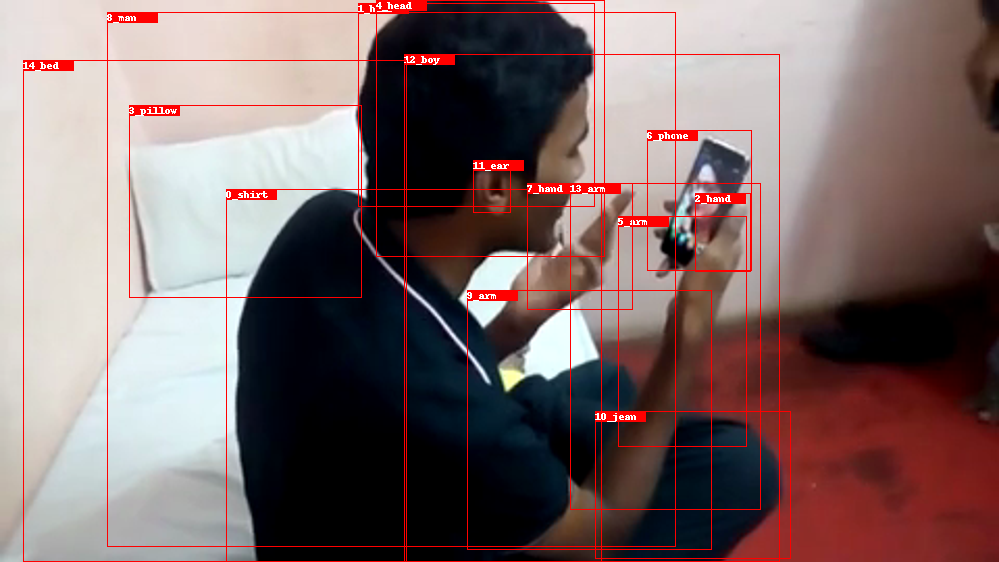

**************************************************
box_labels 0: shirt; score: 0.7075808048248291
box_labels 1: hair; score: 0.5271692872047424
box_labels 2: hand; score: 0.4986962080001831
box_labels 3: pillow; score: 0.4165131449699402
box_labels 4: head; score: 0.2955266833305359
box_labels 5: arm; score: 0.2806929349899292
box_labels 6: phone; score: 0.28028273582458496
box_labels 7: hand; score: 0.27597615122795105
box_labels 8: man; score: 0.26757103204727173
box_labels 9: arm; score: 0.1514447033405304
box_labels 10: jean; score: 0.14350999891757965
box_labels 11: ear; score: 0.14120163023471832
box_labels 12: boy; score: 0.13604813814163208
box_labels 13: arm; score: 0.11746002733707428
box_labels 14: bed; score: 0.11741779744625092
**************************************************
rel_labels 0: 6_phone => in => 2_hand; score: 0.950981855392456
rel_labels 1: 8_man => has => 11_ear; score: 0.8896023631095886
rel_labels 2: 8_man => has => 4_head; score: 0.8847584128379822
rel_la

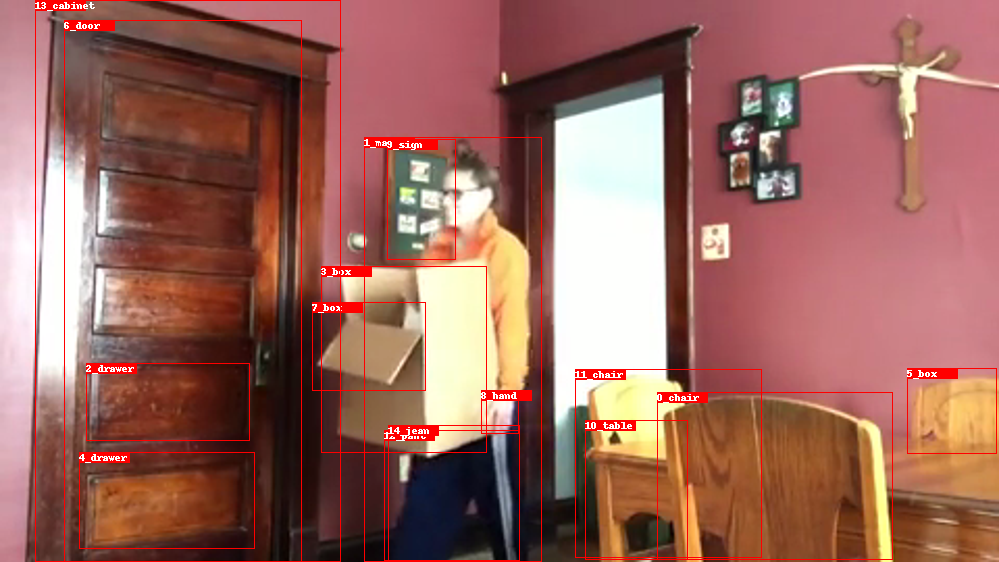

**************************************************
box_labels 0: chair; score: 0.8125182390213013
box_labels 1: man; score: 0.7119564414024353
box_labels 2: drawer; score: 0.6757268905639648
box_labels 3: box; score: 0.4502400755882263
box_labels 4: drawer; score: 0.44028952717781067
box_labels 5: box; score: 0.40657034516334534
box_labels 6: door; score: 0.39123260974884033
box_labels 7: box; score: 0.3728157579898834
box_labels 8: hand; score: 0.3694268465042114
box_labels 9: sign; score: 0.3204750120639801
box_labels 10: table; score: 0.29381343722343445
box_labels 11: chair; score: 0.2903222143650055
box_labels 12: pant; score: 0.2899687588214874
box_labels 13: cabinet; score: 0.2899394929409027
box_labels 14: jean; score: 0.19600391387939453
**************************************************
rel_labels 0: 8_hand => holding => 3_box; score: 0.9588020443916321
rel_labels 1: 11_chair => at => 10_table; score: 0.8654955625534058
rel_labels 2: 3_box => in => 8_hand; score: 0.8068861365

In [ ]:
image_idx = [25,18] # pick any image_idx from 0 to 399
box_topk = 15 # select top k bounding boxes
rel_topk = 15 # select top k relationships
# 18 label 0
# 25 label 1
for i in image_idx:
  visualize_scene_graph(i, box_topk, rel_topk)

In [ ]:
%cd /content/drive/MyDrive/cs224w/pipeline
!git clone https://github.com/gyhandy/Img2SceneGraph

/content/drive/.shortcut-targets-by-id/1TPrMtjhEfnoMUi4EL4VNkiem1ooP9kW3/cs224w/pipeline
fatal: destination path 'Img2SceneGraph' already exists and is not an empty directory.


Run the command below to load our custome dataset as the same format of PyG TUDataset.

In [ ]:
%cd /content/drive/MyDrive/cs224w/pipeline/Img2SceneGraph
!python Data_P.py \
--out_dir /content/drive/MyDrive/cs224w/pipeline/Img2SceneGraph/output \
--root /content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/anno_frames_bicls \
--name ag \
--method a \
--para 0.1 \
--dim 500 \
--max_nodes 100 \
--min_nodes 3 \
--max_edges 100 \
--min_edges 2

/content/drive/.shortcut-targets-by-id/1TPrMtjhEfnoMUi4EL4VNkiem1ooP9kW3/cs224w/pipeline/Img2SceneGraph
/content/drive/MyDrive/cs224w/ActionGenome/dataset/ag/anno_frames_bicls_2
/content/drive/MyDrive/cs224w/pipeline/Img2SceneGraph/output
ag
tcmalloc: large alloc 2924380160 bytes == 0x5606442ac000 @  0x7fecd9e091e7 0x56063e77ff98 0x56063e74ae27 0x56063e8c9115 0x56063e863888 0x56063e74e6f2 0x56063e82cc6e 0x56063e863802 0x56063e74e6f2 0x56063e751926 0x56063e8cc7a3 0x56063e74e349 0x56063e83fe1d 0x56063e7c1e99 0x56063e7bcced 0x56063e74fbda 0x56063e7c1d00 0x56063e74fafa 0x56063e7bd915 0x56063e7bc9ee 0x56063e7bc6f3 0x56063e8864c2 0x56063e88683d 0x56063e8866e6 0x56063e85e163 0x56063e85de0c 0x7fecd8bf3bf7 0x56063e85dcea
tcmalloc: large alloc 2924380160 bytes == 0x5606f2794000 @  0x7fecd9e091e7 0x56063e77ff98 0x56063e7954ec 0x56063e822e93 0x56063e74e349 0x56063e74e240 0x56063e7c20f3 0x56063e7bc9ee 0x56063e750271 0x56063e74f720 0x56063e751698 0x56063e82e441 0x56063e8cc7d1 0x56063e74e349 0x56063e

In [ ]:
!mkdir -p /content/drive/MyDrive/cs224w/Graph_AE/data/ag/ag/processed
!mkdir -p /content/drive/MyDrive/cs224w/Graph_AE/data/ag/ag/raw/
%cd /content/drive/MyDrive/cs224w/pipeline/Img2SceneGraph/output
!cp *.txt /content/drive/MyDrive/cs224w/Graph_AE/data/ag/ag/raw/

/content/drive/.shortcut-targets-by-id/1TPrMtjhEfnoMUi4EL4VNkiem1ooP9kW3/cs224w/pipeline/Img2SceneGraph/output


## 5. Scene Graph Compression

An effective Scene Graph Compression method can obtain a smaller graph, which can reconstruct the original full graph with less storage and can provide useful latent representations to improve
downstream task performance. <br>

Here we refer to the Multi-kernel Inductive Attention Graph Autoencoder (MIAGAE) proposed by [Graph Autoencoder for Graph Compression and Representation Learning (Yunhao G. 2021)](https://openreview.net/pdf?id=Bo2LZfaVHNi), which, instead of compressing
nodes/edges separately, utilizes the node similarity and graph structure to compress all nodes and edges as a whole. Similarity attention graph pooling selects the most representative nodes with the most information by using the similarity and topology among nodes.

![picture](https://drive.google.com/uc?export=view&id=1FUHi4f9nIOMJrRpm58L6tKX8LsEEZrL7)

### 5.1 Scene Graph Compression Model Definition

MIAGAE consists of an encoder network $E$ and a decoder network $D$ (see figure above). To obtain graph compression and reconstruction ability, $E$ first learns to eliminate graph nodes and edges to get a compressed smaller graph, then $D$ learns to add new nodes and reconstruct the original graph.

Here, the single-kernel Inductive-Conv layer in the model is inspired by [GraphSAGE (Hamilton et al., 2017a)](https://arxiv.org/pdf/1706.02216.pdf), which is: <br>
$f_{k+1}^i = W_1f_k^i + W_2 \cdot mean_{j\in\mathcal{N}(i)} f_k^j$. <br>

where $mean$ is the aggregation function, $f_k^i$ denotes the feature of node $v_i$ in layer $k$, $W1$ and $W2$ denote the shared linear transformation parameter for center node vi and neighbor node $v_j$ respectively, $\mathcal{N}(i)$ denotes the neighboring node sets connected to node $i$.

Inspired by CNN layers in the image domain, which have multiple convolution kernels, and each kernel may extract different aspects of a feature, we propose the Multi-kernel Inductive-Conv layer (MI-Conv). Instead of using a single set of transformation weights $W1$ and $W2$, MI-Conv uses multiple kernels, and each kernel has. its corresponding $W1$ and $W2$. Features extracted by the first kernel and final features aggregating all $m$ kernels become: <br>

$f_{k+1, \color{red}1}^i = W_1^{\color{red}1}f_k^i + W_2^{\color{red}1} \cdot mean_{j\in\mathcal{N}(i)} f_k^j$. <br>

$f_{k+1}^i = Aggre(\sigma (f_{k+1, \color{red}1}^i), \sigma (f_{k+1, \color{red}2}^i), ..., \sigma(f_{k+1, \color{red}m}^i))$

where $m$ is the number of kernels; $σ$ represents a non-linear activation function (we use ReLU); $Aggre$ represents an aggregate function to combine the multi-kernel results (we use addition).

From here, let's look detailly into the implementations of Multi-kernel Inductive Attention Graph Autoencoder (MIAGAE).

*Import the libraries related to PyG (torch_geometric).*

In [ ]:
from typing import Union, Tuple, Optional
from torch_geometric.typing import OptPairTensor, Adj, Size, OptTensor

from abc import ABC
import torch
from torch import Tensor
from torch_sparse import SparseTensor, matmul, spspmm, coalesce

from torch.nn import Linear
import torch.nn.functional as F
from torch.nn import Parameter

from torch_geometric.nn import TopKPooling
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import softmax
from torch_geometric.utils import sort_edge_index, add_remaining_self_loops


### 5.1.1 Encoder Layers

1. The first layer implemented here is SAGEAttn Layer, which is included in the Encoder Netowrk layers and is the single-kernel Inductive-Conv layer inspired by [GraphSAGE (Hamilton et al., 2017a)](https://arxiv.org/pdf/1706.02216.pdf). The forward process of this layer is performed as: <br>
$\mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W_2} \cdot \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j$

In [ ]:
class SAGEAttn(MessagePassing):
    r"""The GraphSAGE operator from the `"Inductive Representation Learning on
    Large Graphs" <https://arxiv.org/abs/1706.02216>`_ paper
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{W}_1 \mathbf{x}_i + \mathbf{W_2} \cdot
        \mathrm{mean}_{j \in \mathcal{N(i)}} \mathbf{x}_j
    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
        out_channels (int): Size of each output sample.
        normalize (bool, optional): If set to :obj:`True`, output features
            will be :math:`\ell_2`-normalized, *i.e.*,
            :math:`\frac{\mathbf{x}^{\prime}_i}
            {\| \mathbf{x}^{\prime}_i \|_2}`.
            (default: :obj:`False`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(self, in_channels: Union[int, Tuple[int, int]],
                 out_channels: int, normalize: bool = False,
                 bias: bool = True, **kwargs):  # yapf: disable
        super(SAGEAttn, self).__init__(aggr='mean', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.beta = Parameter(torch.Tensor(1))
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        # set the linear layers
        self.lin_l = Linear(in_channels[0], out_channels, bias=bias)
        self.lin_r = Linear(in_channels[1], out_channels, bias=False)

        self.reset_parameters()

    def reset_parameters(self):
        self.beta.data.fill_(1)
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x: Tensor, edge_index: Adj,
                size: Size = None) -> Tensor:
        """"""
        x_norm = F.normalize(x, p=2., dim=-1)
        x1: OptPairTensor = (x, x)

        # propagate_type: (x: OptPairTensor)
        out = self.propagate(edge_index, x=x, x_norm=x_norm, size=None)
        out = self.lin_l(out)

        alpha = self._alpha
        self._alpha = None

        x_r = x1[1]
        if x_r is not None:
            out += self.lin_r(x_r)

        if self.normalize:
            out = F.normalize(out, p=2., dim=-1)

        return out, alpha

    def message(self, x_j: Tensor, x_norm_i: Tensor, x_norm_j: Tensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        alpha = self.beta * (x_norm_i * x_norm_j).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor,
                              x: OptPairTensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x[0], reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

*Import libraries for SGAT layer, SGConv layer, and Pooling Layer.*

In [ ]:
from torch_geometric.nn.pool.topk_pool import topk, filter_adj
from torch_geometric.nn import global_add_pool as g_pooling
from torch_geometric.utils import sort_edge_index
from torch_sparse import spspmm
from torch_geometric.nn import SAGEConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

2. The second layer that's implemented here is SGAT layer. This layer is the main component of Encoder Network, where implements the Multi-kernel Inductive-Conv layer (MI-Conv), where for each MI-Conv layer we initialize a `gat_list` to store multiple layers of SAGEAttn model(which is implemented above).


In [ ]:
class SGAT(torch.nn.Module, ABC):

    def __init__(self, size, in_channel, out_channel, heads: int = 1):
        super(SGAT, self).__init__()
        self.size = size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.heads = heads
        # self.pm = Parameter(torch.ones([self.size]))
        self.gat_list = torch.nn.ModuleList()

        for i in range(size):
            self.gat_list.append(SAGEAttn(in_channel, out_channel).to(device))

        self.reset_parameters()

    def reset_parameters(self):
        # self.pm.data.fill_(1)
        for conv in self.gat_list:
            conv.reset_parameters()

    def forward(self, x, edge_index, direction=1):
        feature_list = None
        attention_list = []
        # pm = torch.softmax(self.pm, dim=-1)
        idx = 0
        for conv in self.gat_list:
            feature, attn = conv(x, edge_index)
            if feature_list is None:
                feature_list = F.leaky_relu(feature)
            else:
                feature_list += F.leaky_relu(feature)
            attention_list.append(attn)
            idx += 1

        attention_list = torch.stack(attention_list, dim=1)
        if attention_list.shape[1] > 1:
            attention_list = torch.sum(attention_list, dim=1)
        e_batch = edge_index[0]
        node_scores = direction * g_pooling(attention_list, e_batch).view(-1)
        return feature_list, node_scores

### 5.1.2 Decoder Layers

3. The third layer that's implemented here is the SGConv Layer. This is the main component of Decoder Network, which performs Inductive Un-pooling and is the symmetric implementation as SGAT layer. The number of Inductive Un-pooling
layers is the same as the number of SimAGPool layers. The inductive Un-pooling layer has two inputs: the `output graph` from the previous layer and the `edges information` of new nodes, which is the same as the eliminated edges in the corresponding pooling layer in E. The inductive Un-pooling layer has the same parameter settings as the Inductive-Conv layer.

In [ ]:
class SGConv(torch.nn.Module, ABC):

    def __init__(self, size, in_channel, out_channel, heads: int = 1):
        super(SGConv, self).__init__()
        self.size = size
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.heads = heads
        self.gat_list = torch.nn.ModuleList()

        for i in range(size):
            self.gat_list.append(SAGEConv(in_channel, out_channel).to(device))

        self.reset_parameters()

    def reset_parameters(self):
        for conv in self.gat_list:
            conv.reset_parameters()

    def forward(self, x, edge_index):
        feature_list = None
        for conv in self.gat_list:
            feature = conv(x, edge_index)
            if feature_list is None:
                feature_list = [f.leaky_relu(feature)]
            else:
                feature_list += [f.leaky_relu(feature)]
        feature_list = torch.cat(feature_list, dim=-1)

        return feature_list

4. The forth layer implemented here is the Pooling Layer: This is the implementation of Similarity Attention Graph Pooling layer, which is a component of the Encoder. It achieves downsampling on graph data and adaptively selects a subset of nodes/edges to form a new but smaller
graph.

![picture](https://drive.google.com/uc?export=view&id=1u4HUETh8_s5NkyjYJlu1HbWIkOLCB6Es)

In [ ]:
class Pooling(torch.nn.Module, ABC):

    def __init__(self, rate):
        super(Pooling, self).__init__()
        self.rate = rate

    def forward(self, x, edge_index, attention, batch=None, direction=1):
        e_batch = edge_index[0]
        degree = torch.bincount(e_batch)
        node_scores = direction * g_pooling(attention, e_batch).view(-1)
        node_scores = node_scores.mul(degree)

        perm = topk(node_scores, self.rate, batch)

        edge_index, _ = self.augment_adj(edge_index, None, x.size(0))
        edge_index, _ = filter_adj(edge_index, None, perm, num_nodes=node_scores.size(0))
        x = x[perm]
        batch = batch[perm]

        return x, edge_index, batch, perm.view((1, -1))

    # update edges after pooling
    def augment_adj(self, edge_index, edge_weight, num_nodes):
        edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
                                                  num_nodes)
        edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
                                         edge_weight, num_nodes, num_nodes,
                                         num_nodes)
        return edge_index, edge_weight

### 5.1.3 Whole Graph Compression Model Implementation

The whol Graph Compression Model architecture can be shown as the figure, and implemented as below.

![picture](https://drive.google.com/uc?export=view&id=1_ydieF9QaSBt0C7oAZGvmG10tD9XJPur)

In [ ]:
class Net(torch.nn.Module, ABC):

    def __init__(self, input_size, kernels, depth, rate, shapes, device):
        super(Net, self).__init__()
        size = kernels
        self.device = device
        self.depth = depth
        self.direction = 1
        self.down_list = torch.nn.ModuleList()
        self.up_list = torch.nn.ModuleList()
        self.pool_list = torch.nn.ModuleList()
        # encoder
        conv = SGAT(size, input_size, shapes[0])
        self.down_list.append(conv)
        for i in range(self.depth - 1):
            pool = TopKPooling(shapes[i], rate[i])
            self.pool_list.append(pool)
            conv = SGAT(size, shapes[i], shapes[i + 1])
            self.down_list.append(conv)
        pool = TopKPooling(shapes[-1], rate[-1])
        self.pool_list.append(pool)

        # decoder
        for i in range(self.depth - 1):
            conv = SAGEConv(shapes[self.depth - i - 1], shapes[self.depth - i - 2])
            self.up_list.append(conv)
        conv = SAGEConv(shapes[0], input_size)
        self.up_list.append(conv)

    def augment_adj(self, edge_index, edge_weight, num_nodes):
        # edge_index, edge_weight = coalesce(edge_index, edge_weight, num_nodes, num_nodes)
        edge_index, edge_weight = sort_edge_index(edge_index, edge_weight,
                                                  num_nodes)
        edge_index, edge_weight = spspmm(edge_index, edge_weight, edge_index,
                                         edge_weight, num_nodes, num_nodes,
                                         num_nodes)
        return edge_index, edge_weight

    def forward(self, data):
        x, edge_index, y, batch = data.x, data.edge_index, data.y, data.batch
        edge_index, _ = add_remaining_self_loops(edge_index, num_nodes=x.shape[0])

        edge_list = []
        perm_list = []
        shape_list = []
        edge_weight = x.new_ones(edge_index.size(1))

        # forward through encoder
        f, e, b = x, edge_index, batch
        for i in range(self.depth):
            if i < self.depth:
                edge_list.append(e)
            f, attn = self.down_list[i](f, e, self.direction)
            shape_list.append(f.shape)
            f = F.leaky_relu(f)
            f, e, _, b, perm, _ = self.pool_list[i](f, e, edge_weight, b, attn)
            if i < self.depth - 1:
                e, edge_weight = self.augment_adj(e, edge_weight, f.shape[0])
            perm_list.append(perm)
        latent_x, latent_edge = f, e

        # decoder's layer number is symmetric to encoder
        z = f
        for i in range(self.depth):
            index = self.depth - i - 1
            shape = shape_list[index]
            up = torch.zeros(shape).to(self.device)
            p = perm_list[index]
            up[p] = z
            z = self.up_list[i](up, edge_list[index])
            if i < self.depth - 1:
                z = torch.relu(z)

        edge_list.clear()
        perm_list.clear()
        shape_list.clear()

        # return the reconstructed value z,
        # and the latent_x, latent_edge representation between encoder and decoder
        # and batch b
        return z, latent_x, latent_edge, b

### 5.2 Train and save compression model.

In [ ]:
# the training codes ofr compression model
def train_cp(model, optimizer, device, train_set, valid_set, num_epoch, path, m_name):

    for e in range(num_epoch):
        reconstruction_loss = 0
        reconstruction_loss_1 = 0
        for data in train_set:
            optimizer.zero_grad()
            data = data.to(device)
            z, _, _, _ = model(data)

            loss = torch.nn.MSELoss()(z, data.x)
            loss.backward()
            reconstruction_loss += loss.item()
            optimizer.step()

        for data in valid_set:
            data = data.to(device)
            z, _, _, _ = model(data)
            mse_loss = torch.nn.MSELoss()(z, data.x)
            reconstruction_loss_1 += mse_loss.item()

        reconstruction_loss /= len(train_set)
        reconstruction_loss_1 /= len(valid_set)

        print()
        print('Epoch: {:03d}'.format(e))
        print('Training Loss:', reconstruction_loss)
        print('Test Loss:', reconstruction_loss_1)

    if not os.path.exists(path):
        os.makedirs(path)
    torch.save(model.state_dict(), path + m_name + ".ckpt")
    print("model saved")



python train_compression.py
There are several options:

#### General options
 --m, name of model, default MIAGAE, you can choose from MIAGAE, UNet, Gpool, and SAGpool <br>
 --device, default cuda, you can choose from cuda / cpu / cuda:0, etc. <br>
#### Training specific options:
 --d, name of dataset <br>
 --batch, batch size, default 50 <br>
 --e, number of epochs, default 100 <br>
 --lr, learning rate, default 1e-3 <br>
 --model_dir, path to save model, default /data/model/ <br>
 --n_train, number of samples for train set, default 300 <br>
 --n_test, number of samples for test set, default 100 <br>
#### Model specfic options:
 --k, number of kernels for each layer, default 2 <br>
 --depth, depth of encoder and decoder, default 3 <br>
 --c_rate, compression ratio for each layer of encoder, default 0.8 <br>
 --shapes, shape of each layer in encoder (decoder automatically inverts), default 64,64,64 <br>


In [ ]:
# enter the Graph_AE folder and create a model saving folder, if it says the file exists, just ignore.
%cd /content/drive/MyDrive/cs224w/Graph_AE
!mkdir /content/drive/MyDrive/cs224w/Graph_AE/data/model

/content/drive/.shortcut-targets-by-id/1TPrMtjhEfnoMUi4EL4VNkiem1ooP9kW3/cs224w/Graph_AE
mkdir: cannot create directory ‘/content/drive/MyDrive/cs224w/Graph_AE/data/model’: File exists


In [ ]:
!python train_compression.py \
--d ag \
--batch 40 \
--e 300 \
--lr 1e-4 \
--n_train 280 \
--n_test 120 \
--c_rate 0.85 \
--model_dir '/content/drive/MyDrive/cs224w/Graph_AE/data/model'

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)

Epoch: 000
Training Loss: 1.0024194291659765
Test Loss: 0.9909378886222839

Epoch: 001
Training Loss: 0.98252620441573
Test Loss: 0.9646527171134949

Epoch: 002
Training Loss: 0.9557198541504996
Test Loss: 0.9318777720133463

Epoch: 003
Training Loss: 0.9274527387959617
Test Loss: 0.9036611616611481

Epoch: 004
Training Loss: 0.9023988630090441
Test Loss: 0.8789471387863159

Epoch: 005
Training Loss: 0.8788481908185142
Test Loss: 0.8554375867048899

Epoch: 006
Training Loss: 0.8531051192964826
Test Loss: 0.831508735815684

Epoch: 007
Training Loss: 0.8275208473205566
Test Loss: 0.8090688586235046

Epoch: 008
Training Loss: 0.8012406613145556
Test Loss: 0.7857125500837961

Epoch: 009
Training Loss: 0.7795364728995732
Test Loss: 0.7672983904679617

Epoch: 010
Training Loss: 0.7622473793370383
Test Loss: 0.75193086266

## 6. Scene Graph Action Classification

### 6.1 Scene Graph Action Classification Model Definition

GCN classification models are composed of two graph convolutional layers with node feature dimension 64, followed by $l$ layers MLP to output the final classification result. The GCN classifiers used in our customized dataset use $l=4$ with batch normalization.

### 6.2 Train and Test the Classification Model

In [ ]:
# The codes for training classification model
def train_cf(model, optimizer, device, train_set, valid_set, num_epoch, group1, group2):

    for e in range(num_epoch):
        c_loss = 0
        accuracy = 0
        total_num = 0
        for data in train_set:
            optimizer.zero_grad()
            data = data.to(device)
            model.training = True
            c = model(group1[0], group1[1], group1[2])
            label = data.y.long()

            pred = c.argmax(dim=1)
            total_num += label.shape[0]
            accuracy += (pred == label).sum().item()
            c_loss = torch.nn.CrossEntropyLoss()(c, label)
            c_loss.backward()
            optimizer.step()

        accuracy /= total_num
        print()
        print('Epoch: {:03d}'.format(e))
        print('Train Loss:', c_loss.item())
        print('Train Accuracy:', accuracy)

        accuracy = 0
        total_num = 0
        for data in valid_set:
            data = data.to(device)
            model.training = False
            c = model(group2[0], group2[1], group2[2])
            pred = c.argmax(dim=1)
            label = data.y.long()
            total_num += label.shape[0]
            accuracy += (pred == label).sum().item()

        accuracy /= total_num

        print('Test Accuracy:', accuracy)

We can run python train_classifier.py to train the classification model.
There are several options:

#### Parameters that should be the same with compression module:
--m, name of model <br>
--device <br>
--model_dir, path to save model, default /data/model/ <br>
--k, number of kernels for each layer <br>
--depth, depth of encoder and decoder <br>
--c_rate, compression ratio for each layer of encoder <br>
--shapes, shape of each layer in encoder (decoder automatically inverts) <br>

#### Training specific options:
--d, name of dataset, default FRANKENSTEIN <br>
--batch, batch size, default 50 <br>
--e, number of epochs, default 100 <br>
--lr, learning rate, default 1e-3 <br>
--n_skip, skip some number of samples, default 0 <br>
--n_train, number of samples for train set, default 300 <br>
--n_test, number of samples for test set, default 100 <br>
#### Model specfic options:
--hidden, shape of the first layer in encoder, default 256 <br>
--dropout, dropout rate, default 0.1


In [ ]:
!python train_classifier.py \
--d ag \
--n_skip 0 \
--batch 40 \
--e 300 \
--lr 1e-4 \
--n_train 280 \
--n_test 120 \
--c_rate 0.85 \
--model_dir '/content/drive/MyDrive/cs224w/Graph_AE/data/model'

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)

Epoch: 000
Train Loss: 0.752713680267334
Train Accuracy: 0.44642857142857145
Test Accuracy: 0.35

Epoch: 001
Train Loss: 0.7031666040420532
Train Accuracy: 0.5
Test Accuracy: 0.36666666666666664

Epoch: 002
Train Loss: 0.695158839225769
Train Accuracy: 0.48928571428571427
Test Accuracy: 0.36666666666666664

Epoch: 003
Train Loss: 0.7303059697151184
Train Accuracy: 0.475
Test Accuracy: 0.38333333333333336

Epoch: 004
Train Loss: 0.6761115789413452
Train Accuracy: 0.525
Test Accuracy: 0.4

Epoch: 005
Train Loss: 0.6971344947814941
Train Accuracy: 0.48928571428571427
Test Accuracy: 0.39166666666666666

Epoch: 006
Train Loss: 0.7557904720306396
Train Accuracy: 0.4928571428571429
Test Accuracy: 0.4

Epoch: 007
Train Loss: 0.6449453830718994
Train Accuracy: 0.5214285714285715
Test Accuracy: 0.4

Epoch: 008
Train Loss: 0.

### 6.3 Analysis and Limitation

With a compression rate set to 0.85, the final train accuracy is around 0.60 and test accuracy is around 0.56. This suggests our classifier is performing fairly better than randomly guessing the actions of 400 scene graphs.

We expect the accuracies to be higher if we can run our models on the full Action Genome dataset (265K frames across all 157 action categories) because we have already obtained great results using a small subset (400 frames) to classify a binary label (i.e., the "using the phone" action). We look forward to further improving our classification performance if more dataset is used for training/testing.

## 7. Colab Tutorial Conclusion



The graph-based downstream tasks (i.e., action classification) on these graph structures can be further improved if we are given more time and additional computational resources besides Google Colab.

More importantly, it is a fairly difficult task to classify an action only through a single frame. One possible solution can be utilizing a sequence of continuous frames in a video and synthesis the temporal/spatial information together to do a high-level action classification. There are also many other graph ML techniques that can be rather helpful, such as object tracking and dynamic scene graphs.

For the purpose of this tutorial, we want to focus on how to format customized image datasets into graph structures (i.e., scene graph generation) and demonstrate how to do graph compression regarding such complex real-life digital graphs.

## 8. Reference

> Action Genome: https://arxiv.org/abs/1912.06992 <br>
> Unbiased Scene Graph Training: https://arxiv.org/abs/2002.11949 <br>
> Scene Graph Generation by Iterative Message Passing: https://arxiv.org/abs/1701.02426 <br>
> Neural Motifs: https://arxiv.org/abs/1711.06640 <br>
> Graph Autoencoder for Graph Compression: https://openreview.net/forum?id=Bo2LZfaVHNi <br>
> Graph Convolutional Networks: https://arxiv.org/abs/1609.02907
